<a href="https://colab.research.google.com/github/Velociraptorvelraptor/bert-transfer-learning-pubhealth-classification/blob/main/BERT_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision torchtext pytorch-lightning --quiet

In [ ]:
!pip install transformers --quiet

In [ ]:
import pandas as pd

import torch
from torch import nn, optim
import pytorch_lightning as pl
from transformers import BertModel, BertConfig, AutoModel, BertTokenizerFast
from torch.utils.data import DataLoader, TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torchmetrics.functional import accuracy

In [ ]:
!gdown --id 1eTtRs5cUlBP5dXsx-FTAlmXuB6JQi2qj

In [ ]:
!unzip PUBHEALTH.zip

In [ ]:
pubh_train = pd.read_csv('/content/PUBHEALTH/train.tsv', sep='\t')
pubh_test = pd.read_csv('/content/PUBHEALTH/test.tsv', sep='\t')

In [ ]:
pubh_test

,Unnamed: 0,claim_id,claim,date_published,explanation,fact_checkers,main_text,sources,label,subjects
0,0,33456,A mother revealed to her child in a letter aft...,"November 6, 2011",The one-eyed mother story expounds upon two mo...,David Mikkelson,"In April 2005, we spotted a tearjerker on the ...",,false,Glurge Gallery
1,1,2542,Study says too many Americans still drink too ...,"February 25, 2013","On any given day in the United States, 18 perc...",,That means the great majority of Americans sta...,http://bit.ly/X1NVtW,true,Health News
2,2,26678,Viral image Says 80% of novel coronavirus case...,"March 13, 2020",The website Information is Beautiful published...,Paul Specht,"Amid the spread of the novel coronavirus, many...",https://www.facebook.com/informationisbeautifu...,true,"Facebook Fact-checks, Coronavirus, Viral image,"
3,3,40705,An email says that 9-year old Craig Shergold o...,"March 16, 2015",Send greeting or business cards to cancer vict...,Rich Buhler & Staff,Craig Shergold is real and in 1989...,https://www.reddit.com/submit?url=https%3A%2F%...,false,"Inspirational, Pleas"
4,4,35718,"Employees at a Five Guys restaurant in Daphne,...","July 15, 2020","What's undetermined: As of this writing, Five ...",Dan MacGuill,"In July 2020, amid a new wave of nationwide pr...",,unproven,Law Enforcement
...,...,...,...,...,...,...,...,...,...,...
1230,1230,3295,Christmas miracle for Florida dog whose heart ...,NaN,A Florida man was hoping for a Christmas mirac...,Associated Press,The heart of Gerald Ford’s 1-year-old French b...,https://www.gainesville.com/news/20200102/holi...,true,"Animals, Health, Florida, General News, Gaines..."
1231,1231,6904,Another dolphin dies at Arizona aquatic facility.,NaN,A fourth dolphin has died at a Phoenix-area aq...,,A statement from Dolphinaris Arizona in Scotts...,,true,"Arizona, Animals, Phoenix, Health, Dolphins"
1232,1232,13874,"What the facts say"" is ... ""the best scenario ...","July 17, 2016","Priebus said, ""What the facts say"" is ... ""the...",Lauren Carroll,Republican National Committee chairman Reince ...,https://www.nytimes.com/2016/07/13/us/politics...,false,"National, Children, Race and Ethnicity, Reince..."
1233,1233,2847,FDA advisory panel rejects J&J drug for acute ...,"January 16, 2014",Johnson & Johnson’s anticoagulant Xarelto shou...,,"The panel voted 10 to 0, with one abstention, ...",,true,Health News


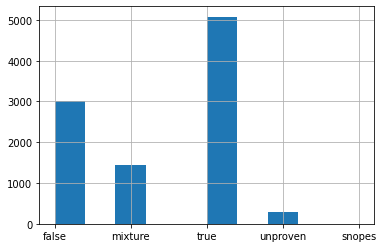

In [ ]:
pubh_train.label.hist()

In [ ]:
pubh_train = pubh_train[pubh_train.label != 'snopes']

In [ ]:
pubh_train = pubh_train[['main_text', 'label']]

In [ ]:
pubh_test = pubh_test[['main_text', 'label']]

In [ ]:
pubh_test.label.unique()

array(['false', 'true', 'unproven', 'mixture', nan], dtype=object)

In [ ]:
pubh_train.dropna(inplace=True)
pubh_test.dropna(inplace=True)

In [ ]:
pubh_train.isna().any()

main_text    False
label        False
dtype: bool

In [ ]:
label_mapper = {'false': 0, 'true': 1, 'unproven': 2, 'mixture': 3}

In [ ]:
pubh_train['label'] = pubh_train['label'].apply(lambda x: label_mapper[x])

In [ ]:
pubh_train.head(5)

,main_text,label
0,"""Hillary Clinton is in the political crosshair...",0
1,While the financial costs of screening mammogr...,3
2,The news release quotes lead researcher Robert...,3
3,"The story does discuss costs, but the framing ...",1
4,"""Although the story didn’t cite the cost of ap...",1


In [ ]:
pubh_test = pubh_test[['main_text', 'label']].dropna()

In [ ]:
pubh_test['label'] =  pubh_test['label'].apply(lambda x: label_mapper[x])

<ipython-input-37-c94b5fb1073d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pubh_test['label'] =  pubh_test['label'].apply(lambda x: label_mapper[x])


In [ ]:
pubh_test.shape

(1007, 2)

In [ ]:
class TextClassifier(pl.LightningModule):
  def __init__(self, max_seq_len=512, batch_size=128, learning_rate=0.001):
    super().__init__()
    self.max_seq_len = max_seq_len
    self.batch_size = batch_size
    self.learning_rate = learning_rate
    self.loss = nn.CrossEntropyLoss()

    self.model = AutoModel.from_pretrained('bert-base-uncased')
    for param in self.model.parameters():
      param.requires_grad = False

    self.new_layers = nn.Sequential(
        nn.Linear(768, 512),  # pre-trained BERT model returns output of shape 768
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, 4),  # 4 is number of classes in the dataset
        nn.LogSoftmax(dim=1)
    )

  def forward(self, encode_id, mask):
    _, x = self.model(encode_id, attention_mask=mask, return_dict=False)
    x = self.new_layers(x)
    return x

  def training_step(self, batch, batch_idx):
    encode_id, mask, targets = batch
    outputs = self(encode_id, mask)
    preds = torch.argmax(outputs, dim=1)
    train_accuracy = accuracy(preds, targets, task='multiclass', num_classes=4)
    loss = self.loss(outputs, targets)
    self.log('train_accuracy', train_accuracy, prog_bar=True, on_step=False, on_epoch=True)
    self.log('train_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
    return {"loss": loss, "train_accuracy": train_accuracy}

  def test_step(self, batch, batch_idx):
    encode_id, mask, targets = batch
    outputs = self.forward(encode_id, mask)
    preds = torch.argmax(outputs, dim=1)
    test_accuracy = accuracy(preds, targets, task='multiclass', num_classes=4)
    loss = self.loss(outputs, targets)
    return {"loss": loss, "test_accuracy": test_accuracy}

  def test_epoch_end(self, outputs):
    test_outs = []
    for test_out in outputs:
      out = test_out['test_accuracy']
      test_outs.append(out)
    total_test_accuracy = torch.stack(test_outs).mean()
    self.log('total_test_accuracy', total_test_accuracy, on_step=False, on_epoch=True)
    return total_test_accuracy

  def configure_optimizers(self):
    optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
    return optimizer

  def prepare_data(self):
    tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

    tokens_train = tokenizer.batch_encode_plus(
        pubh_train['main_text'].tolist(),
        max_length = self.max_seq_len, 
        pad_to_max_length = True,
        truncation = True,
        return_token_type_ids = False
    )

    tokens_test = tokenizer.batch_encode_plus(
        pubh_train['main_text'].tolist(),
        max_length = self.max_seq_len, 
        pad_to_max_length = True,
        truncation = True,
        return_token_type_ids = False
    )

    self.train_seq = torch.tensor(tokens_train['input_ids'])
    self.train_mask = torch.tensor(tokens_train['attention_mask'])
    self.train_y = torch.tensor(pubh_train['label'].tolist())

    self.test_seq = torch.tensor(tokens_test['input_ids'])
    self.test_mask = torch.tensor(tokens_test['attention_mask'])
    self.test_y = torch.tensor(pubh_test['label'].tolist())

  def train_dataloader(self):
    train_dataset = TensorDataset(self.train_seq, self.train_mask, self.train_y)
    self.train_dataloader_obj = DataLoader(train_dataset, batch_size=self.batch_size)
    return self.train_dataloader_obj

  def test_dataloader(self):
    test_dataset = TensorDataset(self.test_seq, self.test_mask, self.test_y)
    self.test_dataloader_obj = DataLoader(test_dataset, batch_size=self.batch_size)
    return self.test_dataloader_obj

In [ ]:
model = TextClassifier()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
trainer = pl.Trainer(max_epochs=10, gpus=-1)
trainer.fit(model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params
------------------------------------------------
0 | loss       | CrossEntropyLoss | 0     
1 | model      | BertModel        | 109 M 
2 | new_layers | Sequential       | 395 K 
------------------------------------------------
395 K     Trainable params
109 M     Non-trainable params
109 M     Total params
439.512   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
